## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 11: Classifers, Notebook 2: SVM

Figures demonstrating SVM

These figures are inspired by those in
http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb
from the book
"Python Data Science Handbook" by Jake VanderPlas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets._samples_generator import make_blobs
from sklearn.svm import SVC
import math
from mpl_toolkits import mplot3d

import seaborn as sns; sns.set()

In [3]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
# Create samples from a blob in this box

def make_blob_in_box(num_samples, random_state, xlo, xhi, ylo, yhi):
    xy, c = make_blobs(n_samples=num_samples, centers=1, random_state=random_state, cluster_std=1)
    x_min = min(xy[:,0])
    x_max = max(xy[:,0])
    y_min = min(xy[:,1])
    y_max = max(xy[:,1])
    xy = [np.array([np.interp(v[0], [x_min, x_max], [xlo, xhi]), 
                    np.interp(v[1], [y_min, y_max], [ylo, yhi])]) for v in xy]
    return np.array(xy)

In [5]:
# Make some distinct blobs

def make_demo_blobs_distinct():
    blob_samples = 50
    v1 = make_blob_in_box(num_samples=blob_samples, random_state=42, xlo= -6, xhi= 0, ylo=1, yhi=5)
    v2 = make_blob_in_box(num_samples=blob_samples, random_state=46, xlo= 0, xhi = 6, ylo=-8, yhi=-3)
    c1 = [0]*len(v1)
    c2 = [1]*len(v2)
    allv = np.append(v1, v2, axis=0)
    allc = np.append(c1, c2, axis=0)
    return (allv, allc)

In [6]:
# Make some overlapping blobs

def make_demo_blobs_overlap():
    blob_samples = 50
    v1 = make_blob_in_box(num_samples=blob_samples, random_state=42, xlo= -2, xhi = 2, ylo = -1, yhi = 3)
    v2 = make_blob_in_box(num_samples=blob_samples, random_state=46, xlo= -1, xhi = 3, ylo= -3, yhi= 1)
    c1 = [0]*len(v1)
    c2 = [1]*len(v2)
    allv = np.append(v1, v2, axis=0)
    allc = np.append(c1, c2, axis=0)
    return (allv, allc)

In [7]:
# Convenience to get the range of X values

def get_X_range(X):
    return [min(X[:, 0])*1.1, max(X[:, 0])*1.1]

In [8]:
# Draw the blobs as a scatter plot

def draw_demo_blobs(X, y, filename):
    x_range = get_X_range(X)
    plt.xlim(x_range[0], x_range[1])
    plt.scatter(X[:, 0], X[:, 1], c=y, s=Scatter_dot_size, cmap='cool')
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure(filename)
    plt.show()

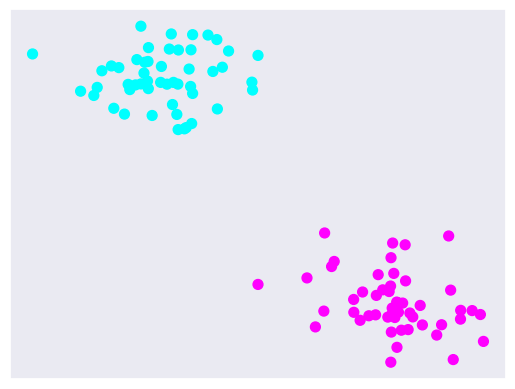

In [9]:
# Show the starting distinct blobs

Scatter_dot_size = 50

X, y = make_demo_blobs_distinct()  
draw_demo_blobs(X, y, 'SVM-demo-blobs-distinct')

In [10]:
# Show some of the lines that could separate these blobs

def draw_possible_lines(X, y, MB_list):
    x_range = get_X_range(X)
    x_values = np.linspace(x_range[0], x_range[1])
    plt.scatter(X[:, 0], X[:, 1], c=y, s=Scatter_dot_size, cmap='cool')
    for slope, intercept in MB_list:
        y_values = intercept+(slope*x_values)
        plt.plot(x_values, intercept+(slope*x_values), '-k')
    plt.xlim(x_range[0], x_range[1])
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure('SVM-possible-lines')
    plt.show()

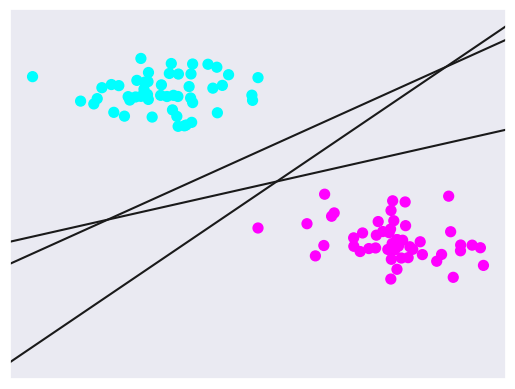

In [11]:
# Hand-chosen lines that separate the blobs

MB_list = [(.5, -2.5), (1, -.5), (1.5, -3)]
draw_possible_lines(X, y, MB_list)

In [12]:
# Find the closest point perpendicular to this line

def get_nearest_vertical_point(X, slope, intercept):
    yvals = [intercept+(slope*x) for x in X[:,0]]
    dvals = [abs(yvals[i] - X[i,1]) for i in range(len(X))]
    i = np.argmin(dvals)
    d = dvals[i]
    return (d, i)

In [13]:
# Draw separating lines along with their support (distance to nearest point)

def draw_possible_lines_with_support(X, y, MB_list):
    x_range = get_X_range(X)
    #y_range = get_Y_range(X)
    y_range = x_range
    x_values = np.linspace(x_range[0], x_range[1])
    plt.figure(figsize=(12,2.5))
    for i in range(len(MB_list)):
        plt.subplot(1, 3, i+1)
        (slope, intercept) = MB_list[i]
        y_values = intercept+(slope*x_values)
        (d, i) = get_nearest_vertical_point(X, slope, intercept)
        plt.scatter([X[i,0]], [X[i,1]], facecolors='none', s=Scatter_dot_size*6, edgecolors='black', 
                    linewidth=2, zorder=50)
        plt.scatter(X[:, 0], X[:, 1], c=y, s=Scatter_dot_size, cmap='cool')
        plt.plot(x_values, intercept+(slope*x_values), '-k')
        plt.fill_between(x_values, y_values-d, y_values+d, edgecolor='none', color='#aaaaaa', alpha=0.4)
        plt.xlim(x_range[0], x_range[1])
        plt.ylim(y_range[0], y_range[1])
        plt.xticks([],[])
        plt.yticks([],[])
        file_helper.save_figure('SVM-possible-lines-with-support')
    plt.show()

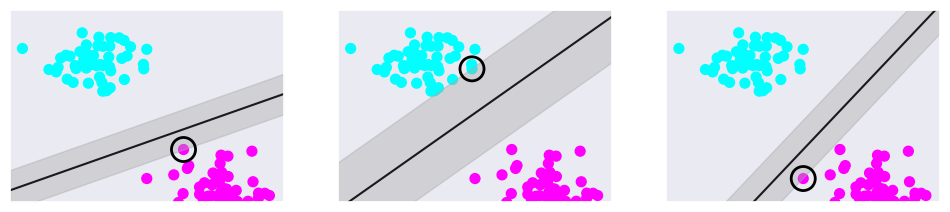

In [14]:
# Show some hand-picked separating lines with their support

draw_possible_lines_with_support(X, y, MB_list)

In [15]:
# Draw the data, along with a boundary line, the support for that line, and its support vectors

def plot_boundary_and_support(X, y, model, support_vectors_alpha, C):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=Scatter_dot_size, cmap='cool')
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_grid = np.linspace(xlim[0], xlim[1], 30)
    y_grid = np.linspace(ylim[0], ylim[1], 30)
    Y_grid, X_grid = np.meshgrid(y_grid, x_grid)
    xy_grid = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T
    P = model.decision_function(xy_grid).reshape(X_grid.shape)

    # plot decision boundary and margins
    ax.contour(X_grid, Y_grid, P, colors='k',
               levels=[-1, 0, 1], alpha=1.0,
               linestyles=['--', '-', '--'])

    sv = model.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], s=Scatter_dot_size*6,  
                    facecolors='none', linewidth=2, zorder=50, 
                    alpha=support_vectors_alpha, cmap='cool')

    x_range = get_X_range(X)
    plt.xlim(x_range[0], x_range[1])
    C_string = 'C ={0:.2f}'.format(C)
    if (C > .01): 
        C_string = 'C = {0:.0e}'.format(C)
    plt.title(C_string)
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure('SVM-C-'+str(C)+'-with-support')
    plt.show()

C:\Users\office27\AppData\Local\Temp\ipykernel_17484\1066645204.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(sv[:,0], sv[:,1], s=Scatter_dot_size*6,


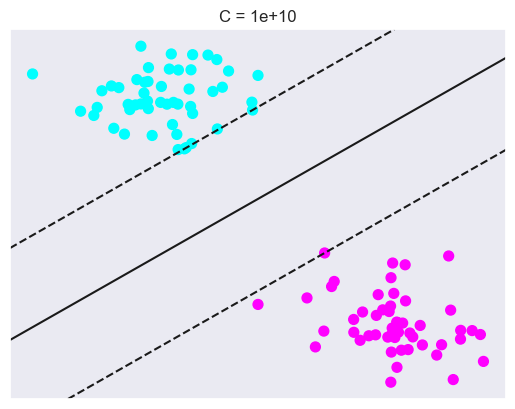

In [16]:
# For this value of C, do run an SVM and plot the results

C=1E10
model = SVC(kernel='linear', C=C)
model.fit(X, y)
plot_boundary_and_support(X, y, model, 1.0, C)

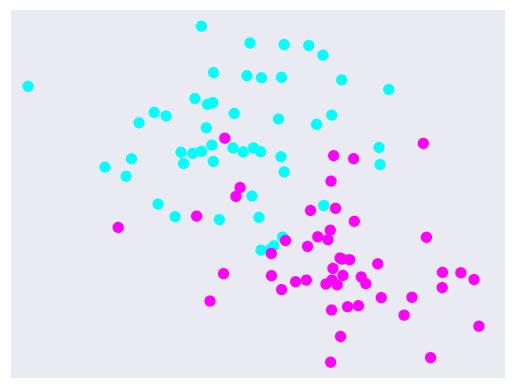

In [17]:
# Show the overlapping blobs

X_overlap, y_overlap = make_demo_blobs_overlap()  
draw_demo_blobs(X_overlap, y_overlap, 'SVM-demo-blobs-overlap')

C:\Users\office27\AppData\Local\Temp\ipykernel_17484\1066645204.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(sv[:,0], sv[:,1], s=Scatter_dot_size*6,


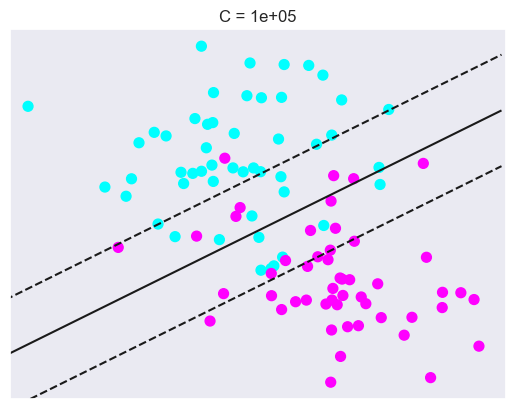

In [18]:
# Run SVM on these blobs

C = 1E5
model = SVC(kernel='linear', C=C)
model.fit(X_overlap, y_overlap)
plot_boundary_and_support(X_overlap, y_overlap, model, 0.4, C)

C:\Users\office27\AppData\Local\Temp\ipykernel_17484\1066645204.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(sv[:,0], sv[:,1], s=Scatter_dot_size*6,


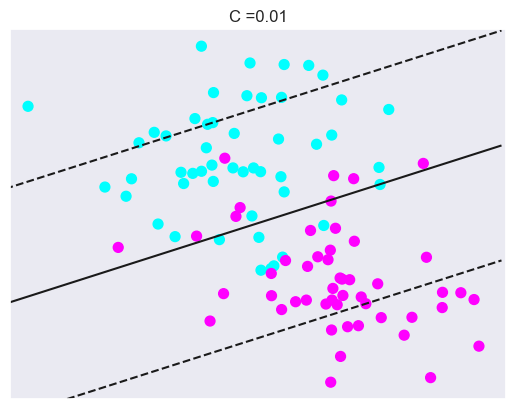

In [19]:
# The overlapping blobs again, but with larger value of C

C=0.01
model = SVC(kernel='linear', C=C)
model.fit(X_overlap, y_overlap)
plot_boundary_and_support(X_overlap, y_overlap, model, 0.2, C)

These cells show the famous blob-in-a-ring example illustrating the SVM kernel trick

In [20]:
# Show a pair of rings

def show_rings_pair(X, y):
    plt.figure(figsize=(6,6))
    lim_lo = np.min(X)
    lim_hi = np.max(X)
    plt.xlim(lim_lo*1.1, lim_hi*1.1)
    plt.ylim(lim_lo*1.1, lim_hi*1.1)
    plt.scatter(X[:,0], X[:,1], c=y, s=Scatter_dot_size, cmap='cool')
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure('SVM-ring-pair')
    plt.show()

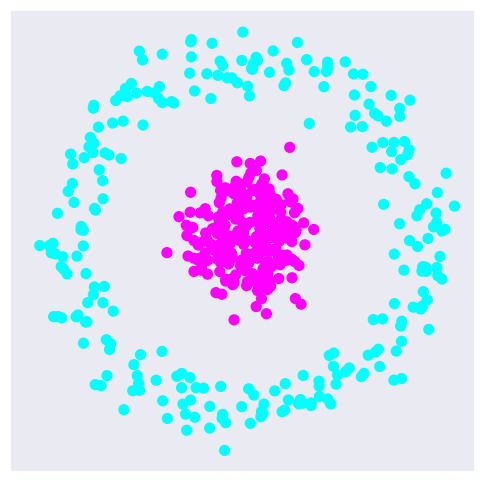

In [21]:
# Show the blob-in-a-ring (we actually use two noisy circles)

from sklearn.datasets import make_circles
X_rings, y_rings = make_circles(n_samples=500, factor=.2, noise=0.1)
show_rings_pair(X_rings, y_rings)

In [22]:
# Add a Z component scaled by distance from the origin

def augment_with_z(X):
    xyz = []
    for xy in X:
        r = math.sqrt((xy[0]*xy[0])+(xy[1]*xy[1]))
        z = r*r
        p = [xy[0], xy[1], z]
        xyz.append(p)
    return np.array(xyz)

In [23]:
# Goofy matplotlib code to show a 3D plot of the data, and a dividing plane

def show_3D_data(X, y):
    plane_z = np.array([[0.35]])
    plt.figure(figsize=(12,5))
    ax = plt.subplot(1, 2, 1, projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y, s=50, cmap='cool', edgecolor='black')
    ps = 2
    xx, yy = np.meshgrid(np.arange(-ps, ps), np.arange(-ps, ps))
    ax.plot_surface(xx, yy, plane_z, color='#ffff00', edgecolor='black')
    ax.view_init(0, 20)
    plt.xlim(-ps, ps)
    plt.ylim(-ps, ps)
    plt.xticks([],[])
    plt.yticks([],[])
    
    ax = plt.subplot(1, 2, 2, projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y, s=50, cmap='cool', edgecolor='black')
    xx, yy = np.meshgrid(np.arange(-ps, ps), np.arange(-ps, ps))
    ax.plot_surface(xx, yy, plane_z, color='#ffff00', edgecolor='black')
    ax.view_init(5, 20)
    plt.xlim(-ps, ps)
    plt.ylim(-ps, ps)
    plt.xticks([],[])
    plt.yticks([],[])
    
    file_helper.save_figure('SVM-3D-rings')
    plt.show()

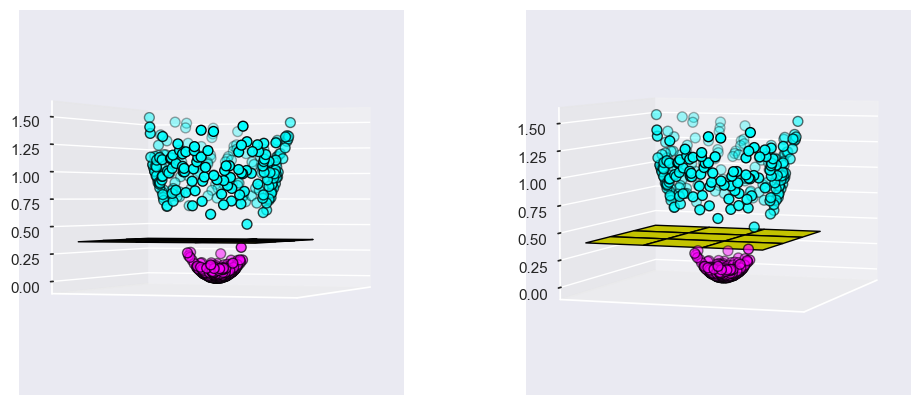

In [24]:
# Show the data with Z, and the dividing plane

Xz = augment_with_z(X_rings)
show_3D_data(Xz, y_rings)

In [25]:
# Show the 3D data, dividing plane, and highlighted support vectors

def show_3D_data_with_supports(X, y, model):
    plane_z = np.array([[0.35]])
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(1, 1, 1, projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y, s=50, cmap='cool', edgecolor='black')
    ps = 2
    xx, yy = np.meshgrid(np.arange(-ps, ps), np.arange(-ps, ps))
    ax.plot_surface(xx, yy, plane_z, color='#ffff00', edgecolor='black')
    ax.view_init(0, 20)
    plt.xlim(-ps, ps)
    plt.ylim(-ps, ps)
    plt.xticks([],[])
    plt.yticks([],[])
    
    ax.scatter3D(Xz[model_rbf.support_][:,0], 
             Xz[model_rbf.support_][:,1],  
             Xz[model_rbf.support_][:,2], s=300, cmap='cool')
    
    file_helper.save_figure('SVM-3Drings-with-supports')
    plt.show()

C:\Users\office27\AppData\Local\Temp\ipykernel_17484\1595306826.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(Xz[model_rbf.support_][:,0],


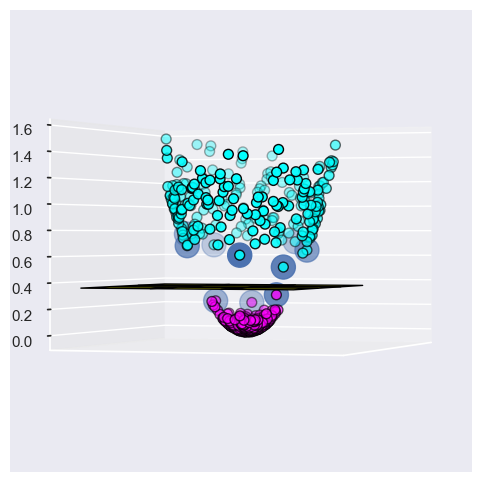

In [26]:
# Run SVM on the blob-and-circle data

model_rbf = SVC(kernel='rbf', C=1E6)
model_rbf.fit(X_rings, y_rings)

show_3D_data_with_supports(Xz, y_rings, model_rbf)

In [27]:
# Project the SVM data down to 2D

def show_2D_data_with_supports(X_rings, y_rings, model_rbf):
    plt.figure(figsize=(6,6))
    plt.scatter(X_rings[:, 0], X_rings[:, 1], c=y_rings, s=Scatter_dot_size, cmap='cool')
    plt.scatter(model_rbf.support_vectors_[:, 0], model_rbf.support_vectors_[:, 1],
                s=6*Scatter_dot_size, lw=3, facecolors='none')
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure('SVM-2Drings-with-supports')
    plt.show()

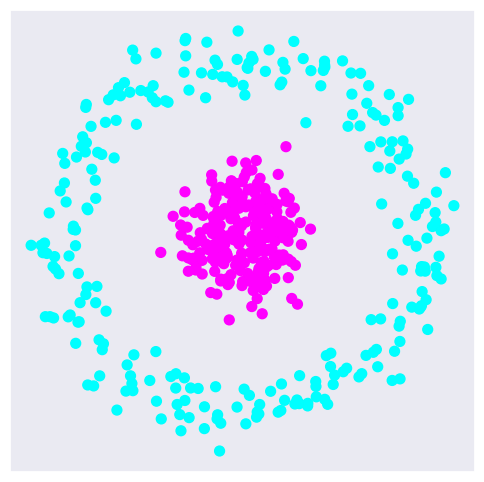

In [28]:
# Show the supports for the blob and circle data

show_2D_data_with_supports(X_rings, y_rings, model_rbf)

In [29]:
# Show the blob and circle data, support vectors, and the curve we get from the
# 3D dividing plane

def show_rings_and_all_SVM_stuff(X_rings, y_rings, model_rbf):
    plt.figure(figsize=(6,6))
    plt.scatter(X_rings[:, 0], X_rings[:, 1], c=y_rings, s=Scatter_dot_size, cmap='cool')
    #plot_svc_decision_function(clf)
    plt.scatter(model_rbf.support_vectors_[:, 0], model_rbf.support_vectors_[:, 1],
                s=6*Scatter_dot_size, lw=3, facecolors='none')

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_grid = np.linspace(xlim[0], xlim[1], 30)
    y_grid = np.linspace(ylim[0], ylim[1], 30)
    Y_grid, X_grid = np.meshgrid(y_grid, x_grid)
    xy_grid = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T
    P = model_rbf.decision_function(xy_grid)
    P = P.reshape(X_grid.shape)

    # plot decision boundary and margins
    ax.contour(X_grid, Y_grid, P, colors='k',
               levels=[-1, 0, 1], alpha=1.0,
               linestyles=['--', '-', '--'])
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure('SVM-rings-and-all-svm')
    plt.show()

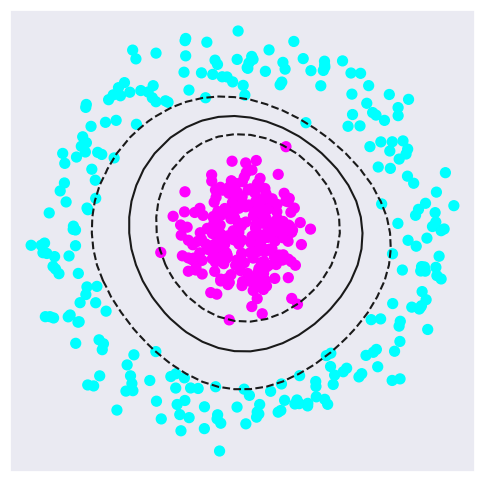

In [30]:
# Show it all in one place

show_rings_and_all_SVM_stuff(X_rings, y_rings, model_rbf)